<a href="https://colab.research.google.com/github/poziryna84/Digit_Recognizer_Kaggle/blob/master/Multi_classification_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from fastai.vision import *

In [0]:
import json

In [0]:
! pip install -q kaggle

In [0]:
pip install kaggle --upgrade # if necessary upgrade it

     |████████████████████████████████| 61kB 6.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=7f1d6db16d5dde3c408c72653209b9592185352528290c4bb743a8c541358117
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.5
    Uninstalling kaggle-1.5.5:
      Successfully uninstalled kaggle-1.5.5


In [0]:
! mkdir ~/.kaggle/

In [0]:
from google.colab import files
import os

In [9]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"poziryna84","key":"e52fcb4c14204b1ee41a14ac3ae9414c"}'}

Ensure kaggle.json is in the location ~/.kaggle/kaggle.json to use the API.


In [0]:
! cp kaggle.json ~/.kaggle/kaggle.json

In [0]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets list

ref                                                       title                                               size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
dgomonov/new-york-city-airbnb-open-data                   New York City Airbnb Open Data                       2MB  2019-08-12 16:24:45          22572  
lakshyaag/india-trade-data                                India - Trade Data                                   1MB  2019-08-16 16:13:58          10792  
therohk/ireland-historical-news                           The Irish Times - Waxy-Wany News                    47MB  2019-08-24 15:36:54           2354  
dareenalharthi/jamalon-arabic-books-dataset               Jamalon Arabic Books Dataset                         1MB  2019-08-15 18:58:06            631  
rajeevw/ufcdata                                           UFC-Fight historical dat

In [13]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/root/.fastai/data/planet')

In [14]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
! unzip -q -n {path}/train_v2.csv.zip -d {path}

 99% 593M/600M [00:09<00:00, 19.9MB/s]
100% 600M/600M [00:09<00:00, 66.5MB/s]
  0% 0.00/159k [00:00<?, ?B/s]
100% 159k/159k [00:00<00:00, 60.7MB/s]


In [0]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
df = pd.read_csv(path/'train_v2.csv')

Multiclassification


In [17]:
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

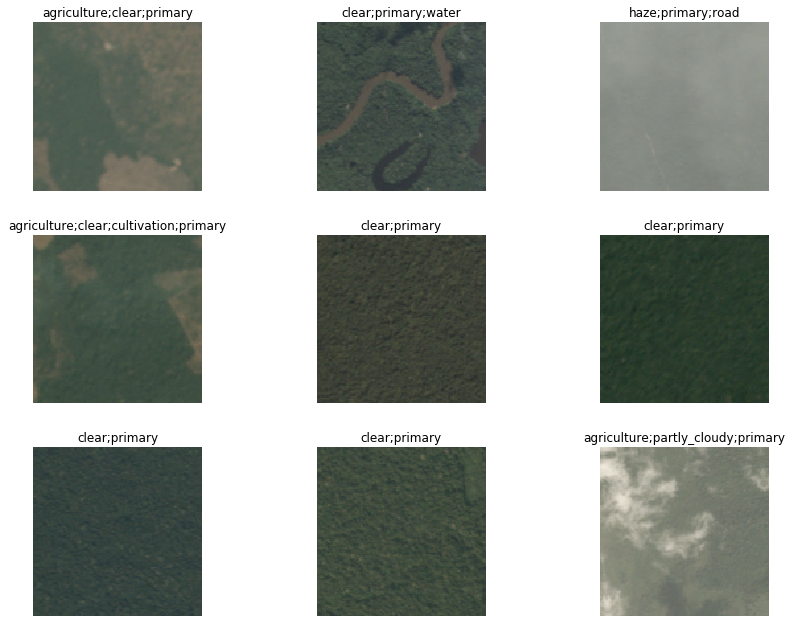

In [21]:
data.show_batch(rows=3, figsize=(12,9))

In [22]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [0]:
arch = models.resnet34

In [24]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:06<00:00, 13.5MB/s]


In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


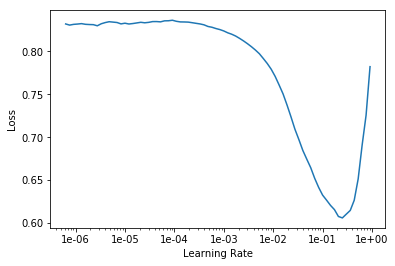

In [0]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [55]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.143474,0.125845,0.940769,0.893767,1:09:26
1,0.115483,0.103140,0.953028,0.910899,1:08:39
2,0.105891,0.098351,0.954714,0.913574,1:08:05
3,0.101503,0.092455,0.953915,0.918925,1:09:04
4,0.094147,0.090709,0.953864,0.921805,1:09:07


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


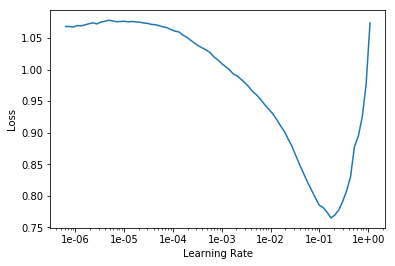

In [27]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.158982,0.117035,0.948261,0.901538,1:37:54
1,0.112884,0.102351,0.950863,0.911970,1:39:05
2,0.100318,0.092761,0.956153,0.920450,1:36:43
3,0.095700,0.088599,0.958297,0.922643,1:41:17
4,0.087715,0.087251,0.956560,0.924502,1:36:54


In [0]:
learn.save('stage-2-rn50')